In [1]:
import cairo
import IPython.display
from io import BytesIO
import numpy as np
import math

class Display():
    def __init__(self, w, h):
        self.svgio = BytesIO()
        self.w = w
        self.h = h
        
    def __enter__(self):
        surface = cairo.SVGSurface(self.svgio, self.w, self.h)
        context = cairo.Context(surface)
        self.surface = surface
        self.context = context
        return self.context
    
    def show(self):
        self.surface.finish()
        self.surface.flush()
        return IPython.display.SVG(data=self.svgio.getvalue())
        
    def __exit__(self, type, value, traceback):
        pass

In [2]:
def diamond_grid_pos(w, h, size):
    x1 = np.concatenate([np.full(h + 1, 0), np.arange(size, w * size, size)])
    y1 = np.concatenate([np.arange(0, h * size, size), np.full(w, h * size)])
    x2 = np.concatenate([np.arange(0, w * size, size), np.full(h, w * size)])
    y2 = np.concatenate([np.full(w, 0), np.arange(0, size * h, size)])
    return np.array([x1, y1, x2, y2]).T

def diamond_grid_neg(w, h, size):
    x1 = np.concatenate([np.full(h + 1, 0), np.arange(size, w * size, size)])
    y1 = np.concatenate([np.arange(h * size, 0, -size), np.full(w, 0)])
    x2 = np.concatenate([np.arange(0, w * size, size), np.full(h, w * size)])
    y2 = np.concatenate([np.full(w, h * size), np.arange(h * size, 0, -size)])
    return np.array([x1, y1, x2, y2]).T

def diamond_grid(w, h, size):
    return np.concatenate([
        diamond_grid_pos(w, h, size),
        diamond_grid_neg(w, h, size)
    ])

def square_grid(w, h, size):
    hor_x1 = np.full(h + 1, 0)
    hor_x2 = np.full(h + 1, w * size)
    hor_y1 = np.arange(0, (h + 1) * size, size)
    hor_y2 = hor_y1
    
    ver_x1 = np.arange(0, (w + 1) * size, size)
    ver_x2 = ver_x1
    ver_y1 = np.full(w + 1, 0)
    ver_y2 = np.full(w + 1, h * size)
    
    return np.concatenate([
            np.array([hor_x1, hor_y1, hor_x2, hor_y2]).T,
            np.array([ver_x1, ver_y1, ver_x2, ver_y2]).T
        ])

def draw_simple_lines(context, lines):
    for row in lines:
        x1, y1, x2, y2 = tuple(row)
        context.move_to(x1, y1)
        context.line_to(x2, y2)
        context.stroke()


In [3]:
def of_multiples(across, down):
    direction = 0
    x = 0
    while True:
        x1 = x
        x2 = x1 + across
        yield ()

def of_order():
    pass

In [4]:
def basic_pattern_lines(size):
    # top, bottom
    yield (0 * size, 0 * size, 15 * size, 0 * size)
    yield (0 * size, 2.5 * size, 15 * size, 2.5 * size)
    
    for i in range(3):
        x = i * size * 5
        # down
        yield (x + 0 * size, 0 * size, x + 2 * size, 2 * size)
        yield (x + 2 * size, 2 * size, x + 2.5 * size, 1.5 * size)

        # up
        x += 0.5
        yield (x + 2.5 * size, 2.5 * size, x + 4.5 * size, .5 * size)
        yield (x + 4.5 * size, .5 * size, x + 5 * size, 1 * size)


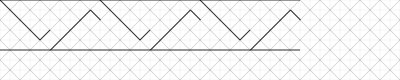

In [5]:
cols = 20
rows = 4
size = 20

display = Display(cols * size, rows * size)

basic_pat = list(basic_pattern_lines(size))

with display as context:
    context.set_line_width(0.5)
    context.set_source_rgba(0, 0, 0, 0.25)
    draw_simple_lines(context, diamond_grid(cols, rows, size))
    context.set_source_rgba(0, 0, 0, 0.08)
    draw_simple_lines(context, square_grid(cols*2, rows*2, size/2))
    
    context.set_line_width(1)
    context.set_source_rgba(0, 0, 0, 0.8)

    draw_simple_lines(context, basic_pat)

display.show()

In [6]:
        
# https://gist.github.com/kylemcdonald/6132fc1c29fd3767691442ba4bc84018
# intersection between line(p1, p2) and line(p3, p4)
def intersect(line1, line2):
    x1,y1,x2,y2 = line1
    x3,y3,x4,y4 = line2
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0: # parallel
        return None
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    if ua < 0 or ua > 1: # out of range
        return None
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
    if ub < 0 or ub > 1: # out of range
        return None
    x = x1 + ua * (x2-x1)
    y = y1 + ua * (y2-y1)
    return (x,y)

def lines_parallel(line1, line2):
    x1,y1,x2,y2 = line1
    x3,y3,x4,y4 = line2
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0: # parallel
        return True
    return False

def line_projection(line1, line2):
    return np.dot(line1, line2) / np.linalg.norm(line2)

def dist(x1, y1, x2, y2):
    return math.sqrt((y2 - y1) ** 2) + math.sqrt((x2 - x1) ** 2)

# https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line#Line_defined_by_two_points
def point_line_dist(x0, y0, line):
    x1, y1, x2, y2 = line
    numerator = abs((x2 - x1) * (y1 - y0) - (x1 - x0) * (y2 - y1))
    denom = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return numerator / denom

# https://stackoverflow.com/questions/1243614/
def normals(line):
    x1, y1, x2, y2 = line
    dx = x2 - x1 
    dy = y2 - y1
    n = np.array([[-dy, dx],
                  [dy, -dx]])
    return n / abs(n).max()

def _parallel_lines_overlap(line1, line2, max_d):
    # - project normals of ends of one line to another, test if intersect
    for pt in np.array(line1).reshape(2,2):
        for n in normals(line1):
            normal_ray = (*pt, *(pt + n * max_d))
            if intersect(normal_ray, line2):
                return True
    return False

def parallel_lines_overlap(line1, line2, max_d):
    return _parallel_lines_overlap(line1, line2, max_d) or \
        _parallel_lines_overlap(line2, line1, max_d)


In [9]:
def path_find(position, direction, walls, size):
    # rough algorithm
    '''
    - Continue in current direction until intersect with wall
    - Backtrack 1/2 square from nearest intersection point
    - Bifurcate in two directions parallel to wall
    - ...
    - Find all adjacent parallel walls within 1/2 square
    - Pick one ending earliest
    - Find any intersections, if intersection <= 1/2 square distant it is invalid
    - If no intersections, double back along the aforementioned earliest wall by following to its end + 1/2 square
    - start again from top
    '''
    xs = np.concatenate([
        np.array(walls)[:,0],
        np.array(walls)[:,2]
    ])
    ys = np.concatenate([
        np.array(walls)[:,1],
        np.array(walls)[:,3]
    ])
    min_x, max_x = xs.min(), xs.max()
    min_y, max_y = ys.min(), ys.max()

    # ...find and follow shortest adjacent parallel wall

    ray = np.array([
        position[0],
        position[1],
        position[0] + direction[0] * 10,
        position[1] + direction[1] * 10
    ]) * size

    # ... how to double back:
    # - 1/4 past end of line
    # - 1/4 distance in direction of normal closes to end
    # - 1/4 forward in opposite direction to start
    

    adjacent = []
    intersecting = []
    for wall in walls:
        if lines_parallel(tuple(ray), tuple(wall)) and \
            parallel_lines_overlap(tuple(ray), tuple(wall), 0.25 * size):
            yield wall
            adjacent.append(wall)

        point = intersect(tuple(ray), tuple(wall))
        if point is not None:
            intersecting.append((point, wall, dist(*point, *position)))

    if len(intersecting):
        nearest = sorted(intersecting, key=lambda v: v[2])[0]
        yield nearest[1]

    yield ray


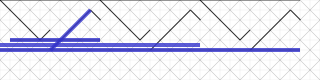

In [10]:

cols = 16
rows = 4
size = 20
display = Display(cols * size, rows * size)

test_pat = np.concatenate([basic_pat, np.array([[0.5,2,5,2]]) * size])

with display as context:
    context.set_line_width(0.5)
    context.set_source_rgba(0, 0, 0, 0.25)
    draw_simple_lines(context, diamond_grid(cols, rows, size))
    context.set_source_rgba(0, 0, 0, 0.08)
    draw_simple_lines(context, square_grid(cols*2, rows*2, size/2))
    
    context.set_line_width(1)
    context.set_source_rgba(0, 0, 0, 0.8)

    draw_simple_lines(context, test_pat)

    context.set_line_width(4)
    context.set_source_rgba(0.2, 0.2, 0.8, 0.8)

    draw_simple_lines(context, list(
        path_find((0,2.25), (1,0), test_pat, size)
    ))


display.show()